Project plan,
1. Vector autoregression
    1. Confirm stationarity using ADF
    2. Plot ACF, PACF
    3. Decomposition
    4. Create [VAR model](https://www.statsmodels.org/dev/vector_ar.html)
    5. Tests: Granger causality, residual whiteness
    6. Create impulse response function visualization


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import altair as alt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

In [43]:
mood = pd.read_csv('../data/emoods.csv', parse_dates=['DATE (YYYY-MM-DD)'], usecols=['DATE (YYYY-MM-DD)', 'IRRITABILITY', 'ANXIETY', 'DEPRESSED', 'ELEVATED']).rename(columns={'DATE (YYYY-MM-DD)':'date', 'IRRITABILITY':'irritable', 'ANXIETY':'anxious', 'DEPRESSED':'depressed','ELEVATED':'elevated'}).set_index('date')
sleep = pd.read_csv('../data/oura_sleep_2023-03-03T12-21-33.csv', parse_dates=['day', 'bedtime_end', 'bedtime_start']).set_index('day')
sleep_scores = pd.read_csv('../data/oura_daily-sleep_2023-03-03T12-20-39.csv', parse_dates=['day']).rename(columns={'contributors_timing':'timing', 'contributors_deep_sleep':'deep', 'contributors_restfulness':'restfulness', 'contributors_efficiency':'efficiency', 'contributors_latency':'latency','contributors_rem_sleep':'rem', 'contributors_total_sleep':'total'}).set_index('day')

In [44]:
sleep_stats = pd.DataFrame(
    columns=['Mean score','Standard deviation', 'Total nights', 'Missing nights', 'Score max', 'Score min'], 
    data=[[round(sleep_scores['score'].mean(), 2), 
           round(sleep_scores['score'].std(), 2),
           sleep_scores['score'].count(),
           sleep_scores['score'].isna().sum(),
           sleep_scores['score'].max(),
           sleep_scores['score'].min()]]
)

print(sleep_stats.T.to_latex())

\begin{tabular}{lr}
\toprule
{} &        0 \\
\midrule
Mean score         &    73.82 \\
Standard deviation &    12.36 \\
Total nights       &  1455.00 \\
Missing nights     &     1.00 \\
Score max          &    97.00 \\
Score min          &    30.00 \\
\bottomrule
\end{tabular}



/var/folders/h2/j2rcc6sn4_vcqzgfkx3nnts40000gn/T/ipykernel_99099/3794196580.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sleep_stats.T.to_latex())


In [45]:
print(mood[mood[['irritable' ,'anxious','depressed','elevated']]>0].count().to_markdown())

|           |   0 |
|:----------|----:|
| irritable | 100 |
| anxious   |  88 |
| depressed | 103 |
| elevated  |  48 |


In [46]:
ts = sleep_scores.join(mood).join(sleep['average_hrv'])

In [47]:
ts.head(10).T

day,2019-02-05,2019-02-06,2019-02-06,2019-02-06,2019-02-06,2019-02-08,2019-02-08,2019-02-09,2019-02-09,2019-02-10
score,65.0,51.0,51.0,51.0,51.0,71.0,71.0,52.0,52.0,34.0
timing,41.0,10.0,10.0,10.0,10.0,1.0,1.0,74.0,74.0,18.0
deep,11.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0
restfulness,73.0,66.0,66.0,66.0,66.0,60.0,60.0,63.0,63.0,74.0
efficiency,98.0,96.0,96.0,96.0,96.0,83.0,83.0,96.0,96.0,55.0
latency,91.0,99.0,99.0,99.0,99.0,88.0,88.0,90.0,90.0,19.0
rem,97.0,79.0,79.0,79.0,79.0,100.0,100.0,40.0,40.0,54.0
total,59.0,34.0,34.0,34.0,34.0,100.0,100.0,35.0,35.0,23.0
irritable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anxious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# considering only Oura sleep score for now
test_ts = ts['score'].dropna()

# 1. Vector autoregression

## 1.1 Stationarity

In [49]:
def test_stationarity(timeseries):
    
    # set figure size
    fig = plt.figure(figsize=(18,8))
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=7).mean() 
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [50]:
from pmdarima.arima.utils import ndiffs

def test_arima(timeseries):
    Adf_Test = ndiffs(timeseries, test='adf')  
    KPSS_Test = ndiffs(timeseries, test='kpss')  
    PP_Test = ndiffs(timeseries, test='pp')  

    print('Number of differences to make stationary, via pymdarima library')
    print('ADF: ', Adf_Test, 'KPSS: ', KPSS_Test, 'PP: ', PP_Test)


### 1.1.1 Using pmdarima library

In [84]:
from pmdarima.arima.stationarity import ADFTest

print('Should we diff Sleep Score?', ADFTest(alpha=0.05).should_diff(ts['score'].dropna()))
print('Should we diff Depressed?', ADFTest(alpha=0.05).should_diff(ts['depressed'].dropna()))
print('Should we diff Anxious?', ADFTest(alpha=0.05).should_diff(ts['anxious'].dropna()))
print('Should we diff Irritable?', ADFTest(alpha=0.05).should_diff(ts['irritable'].dropna()))
print('Should we diff Elevated?', ADFTest(alpha=0.05).should_diff(ts['elevated'].dropna()))

Should we diff Sleep Score? (0.01, False)
Should we diff Depressed? (0.01, False)
Should we diff Anxious? (0.01, False)
Should we diff Irritable? (0.01, False)
Should we diff Elevated? (0.01, False)


### 1.1.2 Using statsmodels (exploratory)

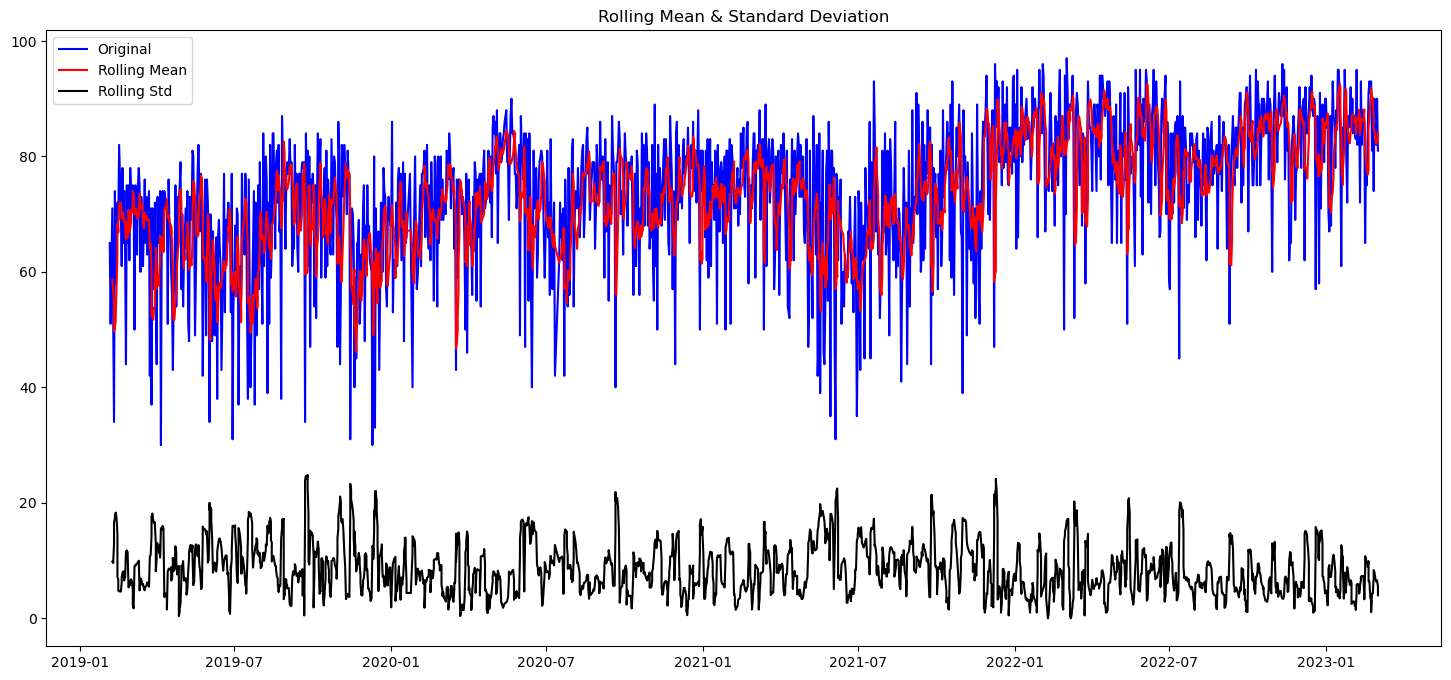

Results of Dickey-Fuller Test:
Test Statistic                   -4.026838
p-value                           0.001276
#Lags Used                       25.000000
Number of Observations Used    2516.000000
Critical Value (1%)              -3.432952
Critical Value (5%)              -2.862689
Critical Value (10%)             -2.567382
dtype: float64
Number of differences to make stationary, via pymdarima library
ADF:  0 KPSS:  1 PP:  0


In [52]:
test_stationarity(test_ts)
test_arima(test_ts)

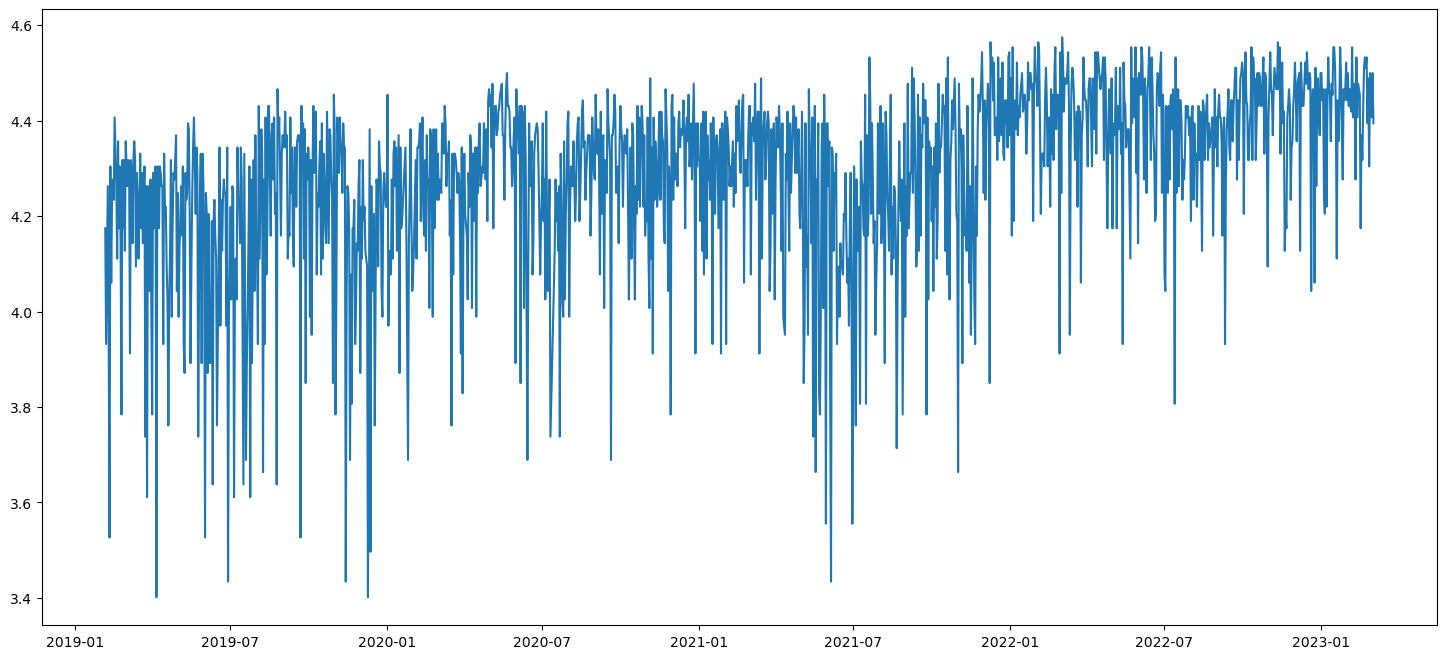

In [53]:
fig = plt.figure(figsize=(18,8))

ts_log = np.log(test_ts).dropna()
plt.plot(ts_log)

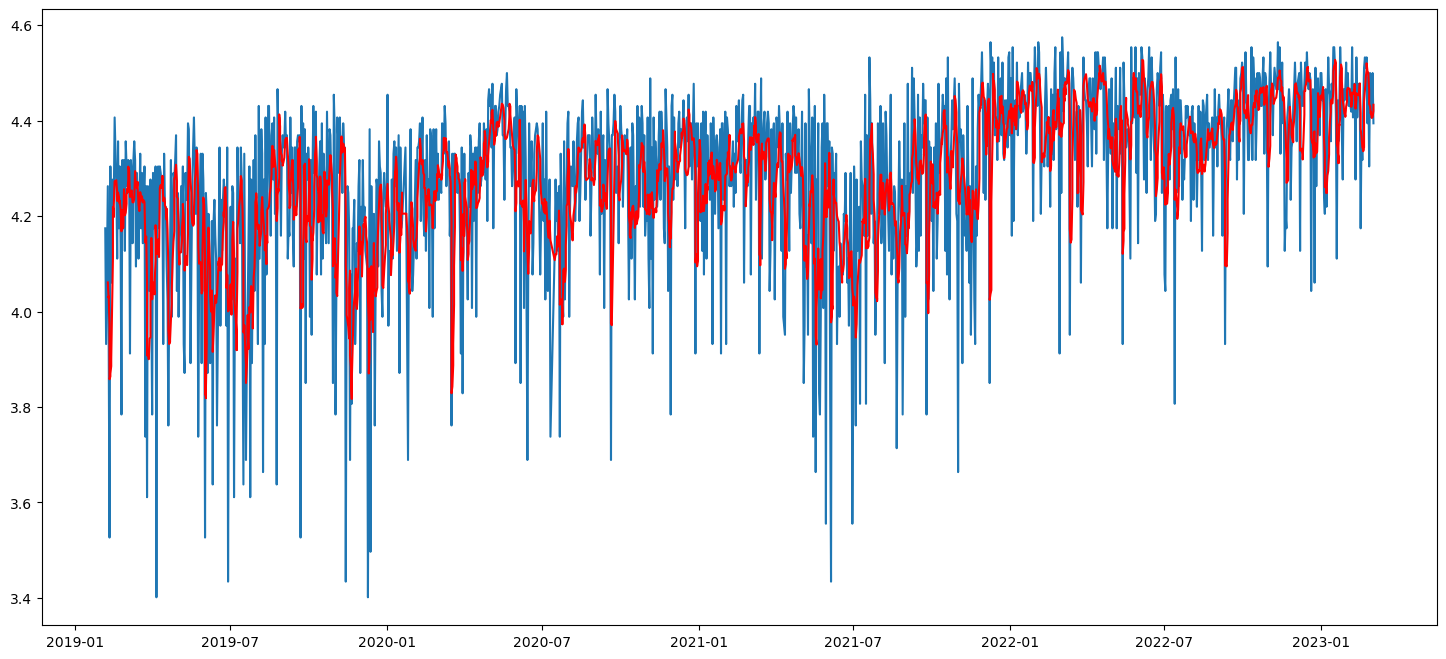

In [54]:
fig = plt.figure(figsize=(18,8))

moving_avg = ts_log.rolling(window=7).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [55]:
ts_log_moving_avg_diff = ts_log - moving_avg

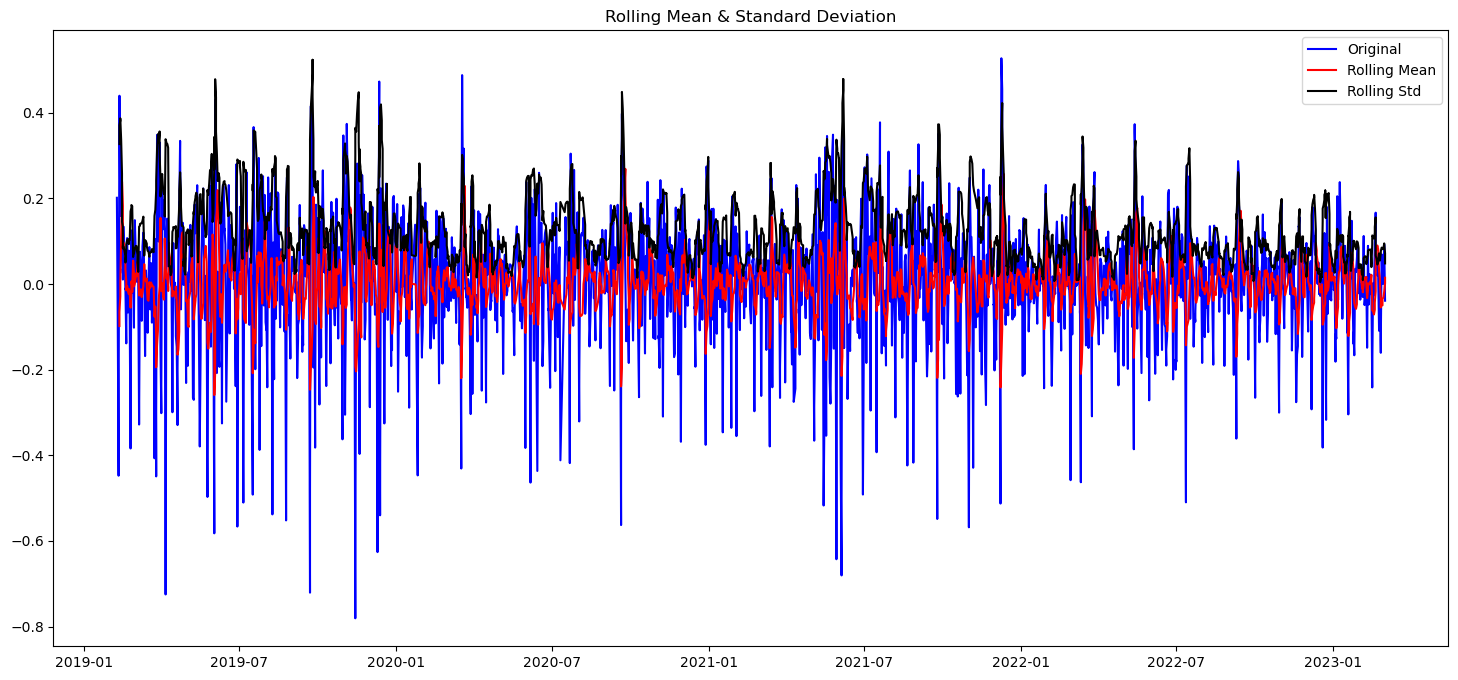

Results of Dickey-Fuller Test:
Test Statistic                -1.470353e+01
p-value                        2.921374e-27
#Lags Used                     2.700000e+01
Number of Observations Used    2.508000e+03
Critical Value (1%)           -3.432960e+00
Critical Value (5%)           -2.862693e+00
Critical Value (10%)          -2.567384e+00
dtype: float64


In [56]:
test_stationarity(ts_log_moving_avg_diff.dropna())


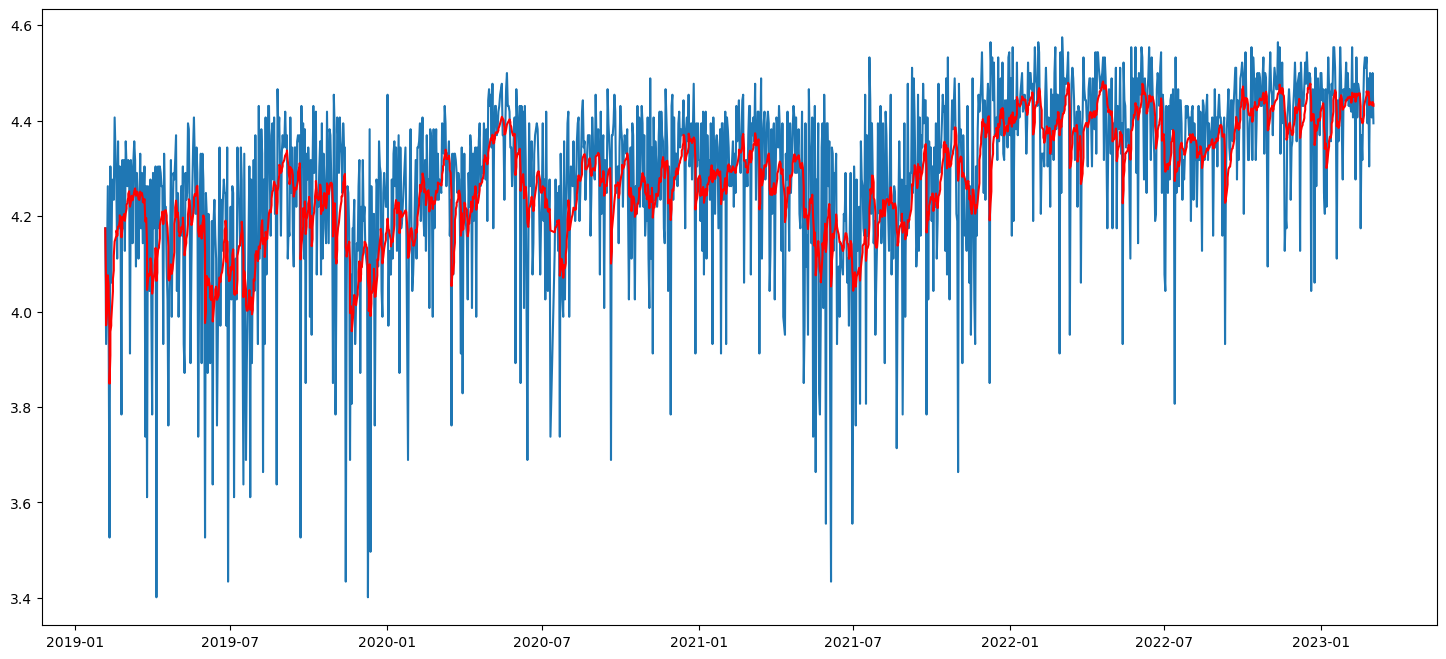

In [57]:
fig = plt.figure(figsize=(18,8))

expweighted_avg = ts_log.ewm(halflife=7).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

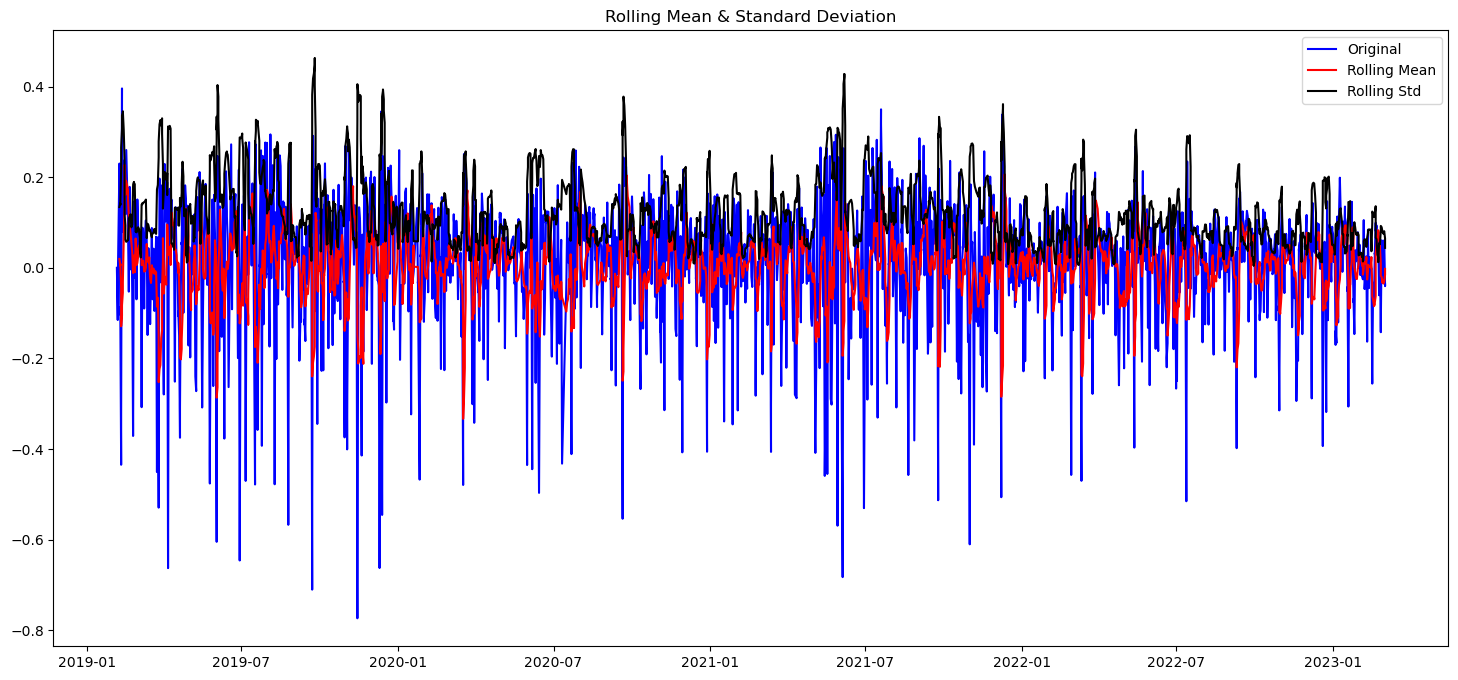

Results of Dickey-Fuller Test:
Test Statistic                  -22.202265
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    2536.000000
Critical Value (1%)              -3.432931
Critical Value (5%)              -2.862680
Critical Value (10%)             -2.567377
dtype: float64
Number of differences to make stationary, via pymdarima library
ADF:  0 KPSS:  1 PP:  0


In [58]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)
test_arima(test_ts)

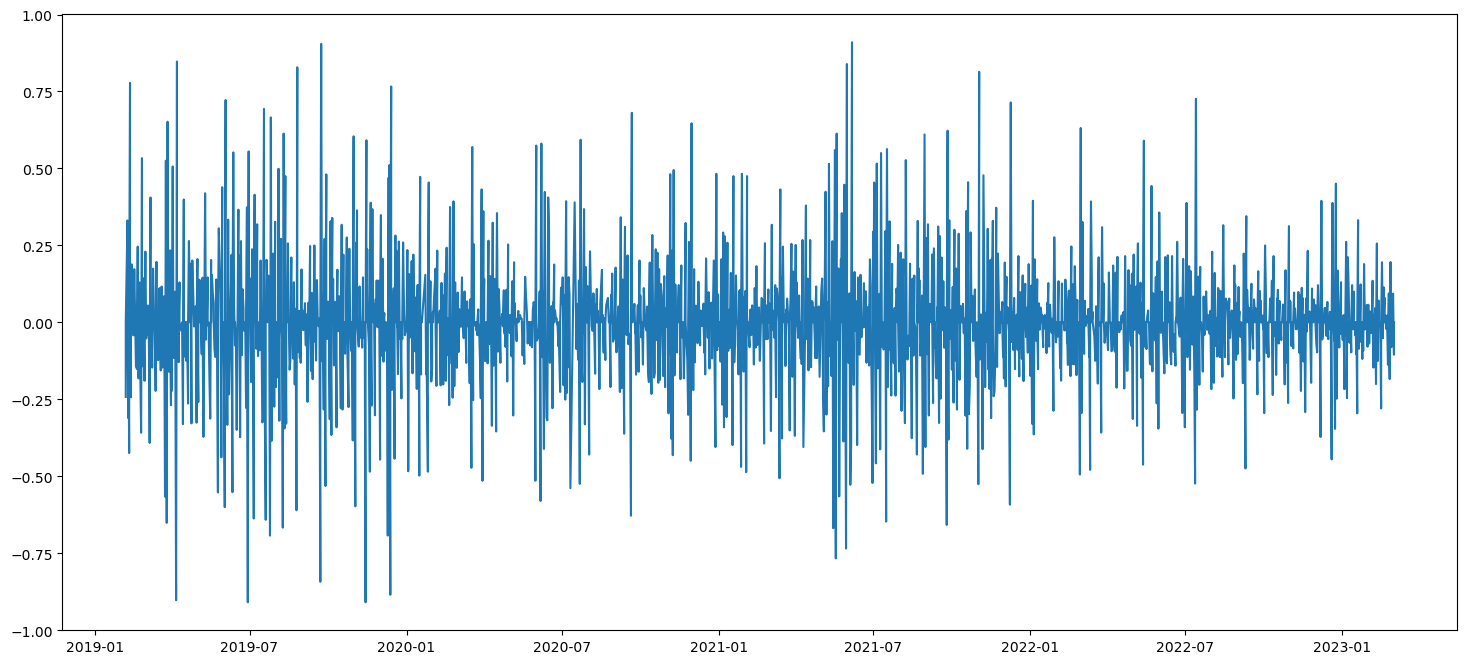

In [59]:
fig = plt.figure(figsize=(18,8))

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

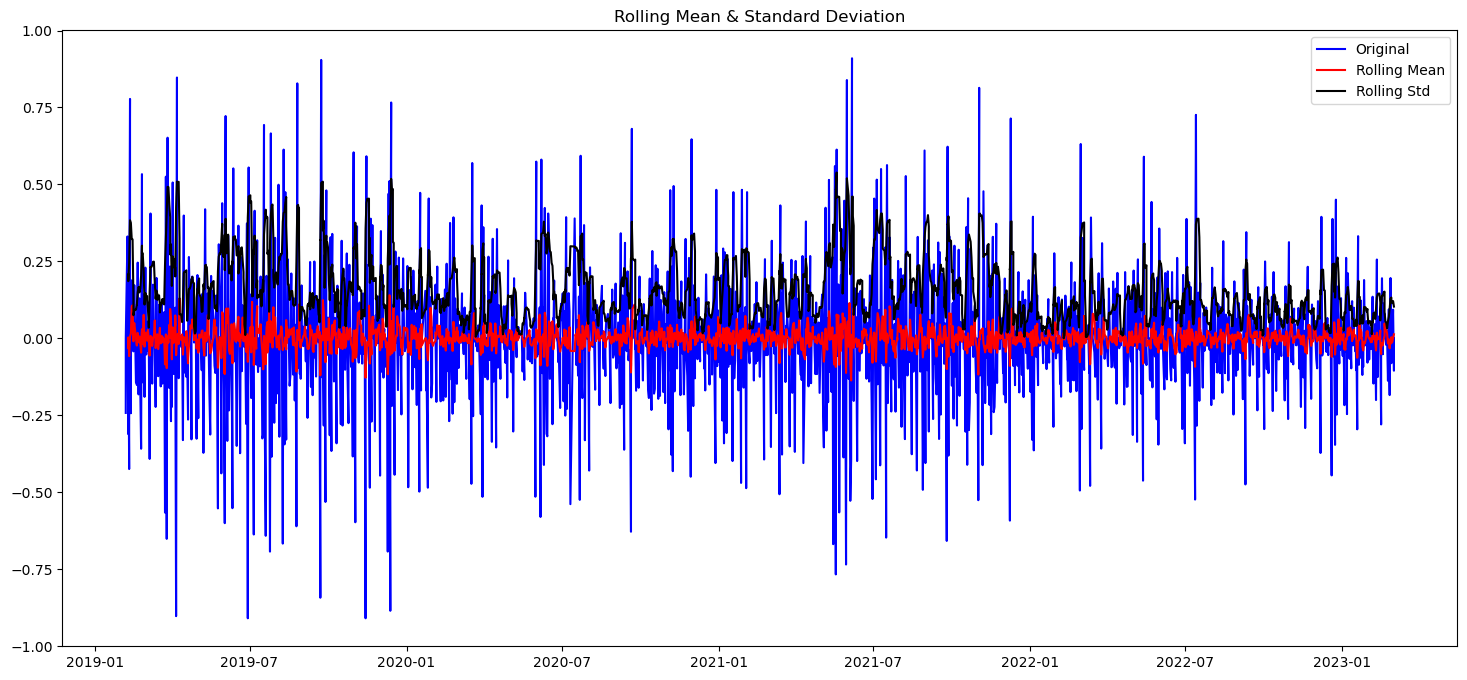

Results of Dickey-Fuller Test:
Test Statistic                -1.674920e+01
p-value                        1.338308e-29
#Lags Used                     2.400000e+01
Number of Observations Used    2.516000e+03
Critical Value (1%)           -3.432952e+00
Critical Value (5%)           -2.862689e+00
Critical Value (10%)          -2.567382e+00
dtype: float64


In [60]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

**Based on pmdarima ADF, choosing not to difference.**

## 1.2 ACF, PACF

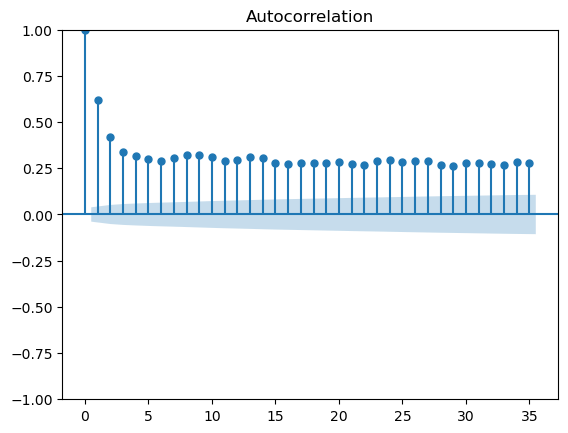

In [61]:
plot_acf(test_ts).savefig('plots/acf.png',dpi=300);

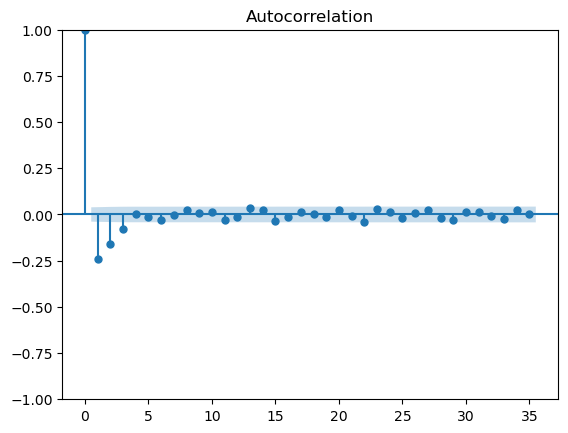

In [62]:
plot_acf(test_ts.diff(), missing='drop');

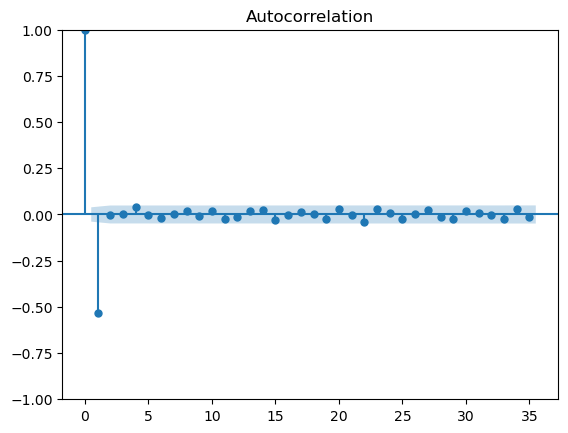

In [63]:
plot_acf(test_ts.diff().diff(), missing='drop');

/opt/homebrew/Caskroom/miniforge/base/envs/stat508_x86/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


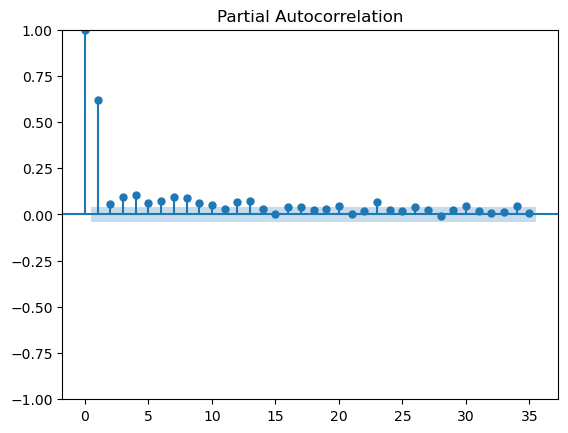

In [64]:
plot_pacf(test_ts).savefig('plots/pacf.png', dpi=300);

## 1.3 Decomposition

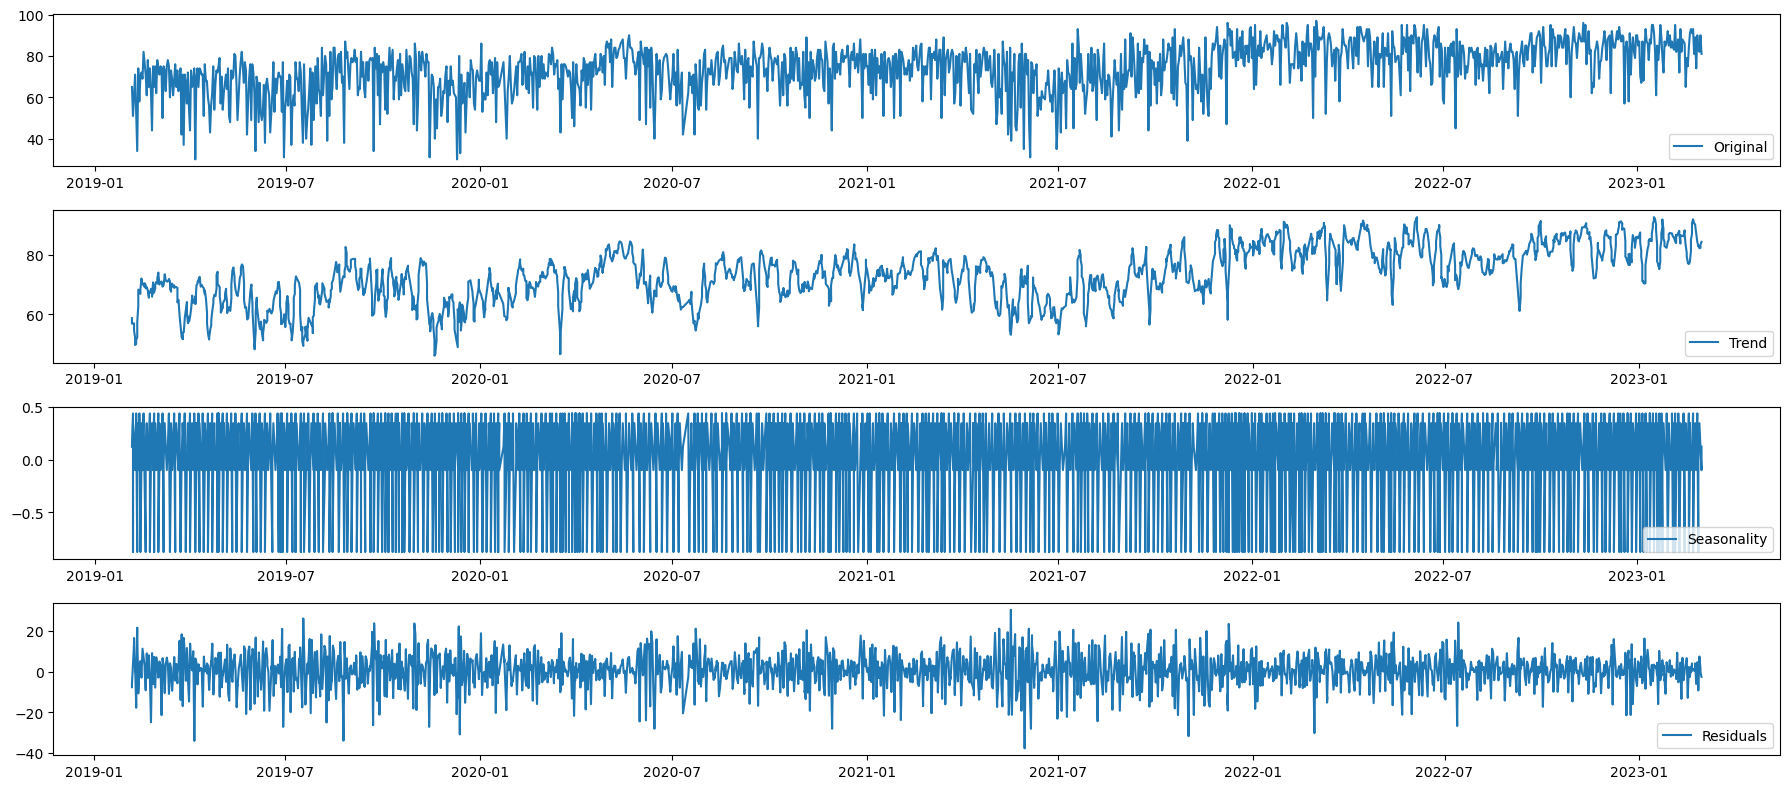

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(test_ts, period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(18,8))

plt.subplot(411)
plt.plot(test_ts, label='Original')
plt.legend(loc='lower right')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='lower right')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='lower right')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig('plots/decomposition.png', dpi=300)

## 1.4 Create VAR model

In [66]:
from statsmodels.tsa.api import VAR

model_var = VAR(ts[['score', 'anxious', 'depressed', 'irritable', 'elevated']].dropna())

# lag order selection
print(model_var.select_order(15).summary().as_latex_tabular())

/opt/homebrew/Caskroom/miniforge/base/envs/stat508_x86/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


\begin{center}
\begin{tabular}{lcccc}
\toprule
            & \textbf{AIC} & \textbf{BIC} & \textbf{FPE} & \textbf{HQIC}  \\
\midrule
\textbf{0}  &       1.688  &       1.708  &       5.408  &        1.695   \\
\textbf{1}  &    -0.02482  &    0.09412*  &      0.9755  &     0.01979*   \\
\textbf{2}  &   -0.03545*  &      0.1826  &     0.9652*  &      0.04635   \\
\textbf{3}  &    -0.03417  &      0.2830  &      0.9664  &      0.08481   \\
\textbf{4}  &    -0.02907  &      0.3872  &      0.9714  &       0.1271   \\
\textbf{5}  &    -0.02537  &      0.4900  &      0.9750  &       0.1680   \\
\textbf{6}  &    -0.01701  &      0.5975  &      0.9832  &       0.2135   \\
\textbf{7}  &    -0.01940  &      0.6943  &      0.9809  &       0.2483   \\
\textbf{8}  &    -0.01014  &      0.8026  &      0.9900  &       0.2948   \\
\textbf{9}  &  -0.0008049  &      0.9111  &      0.9993  &       0.3413   \\
\textbf{10} &     0.01201  &       1.023  &       1.012  &       0.3913   \\
\textbf{11} &     0.

In [76]:
results_var = model_var.fit(2)
results_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, May, 2023
Time:                     10:10:28
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   0.172529
Nobs:                     1318.00    HQIC:                 0.0373163
Log likelihood:          -9266.95    FPE:                   0.957154
AIC:                   -0.0437932    Det(Omega_mle):        0.918193
--------------------------------------------------------------------
Results for equation score
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               27.135187         1.751049           15.497           0.000
L1.score             0.633262         0.027574           22.966           0.000
L1.anxious           0.153275         0.446110            0.344 

## 1.6 Tests: Granger Causality, Normality

In [77]:
print(results_var.test_causality(['depressed'], 'score', kind='f').summary())
print(results_var.test_causality(['anxious'], 'score', kind='f').summary())
print(results_var.test_causality(['irritable'], 'score', kind='f').summary())
print(results_var.test_causality(['elevated'], 'score', kind='f').summary())


Granger causality F-test. H_0: score does not Granger-cause depressed. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         5.384          2.997   0.005 (2, 6535)
-----------------------------------------------
Granger causality F-test. H_0: score does not Granger-cause anxious. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         3.294          2.997   0.037 (2, 6535)
-----------------------------------------------
Granger causality F-test. H_0: score does not Granger-cause irritable. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.347          2.997   0.260 (2, 6535)
-----------------------------------------------
Granger causality F-test. H_0: score does not Granger-caus

In [69]:
results_var.test_normality().summary()

Test statistic,Critical value,p-value,df
4.310e+04,18.31,0.000,10


## 1.7 Visualization: Impulse Response Function

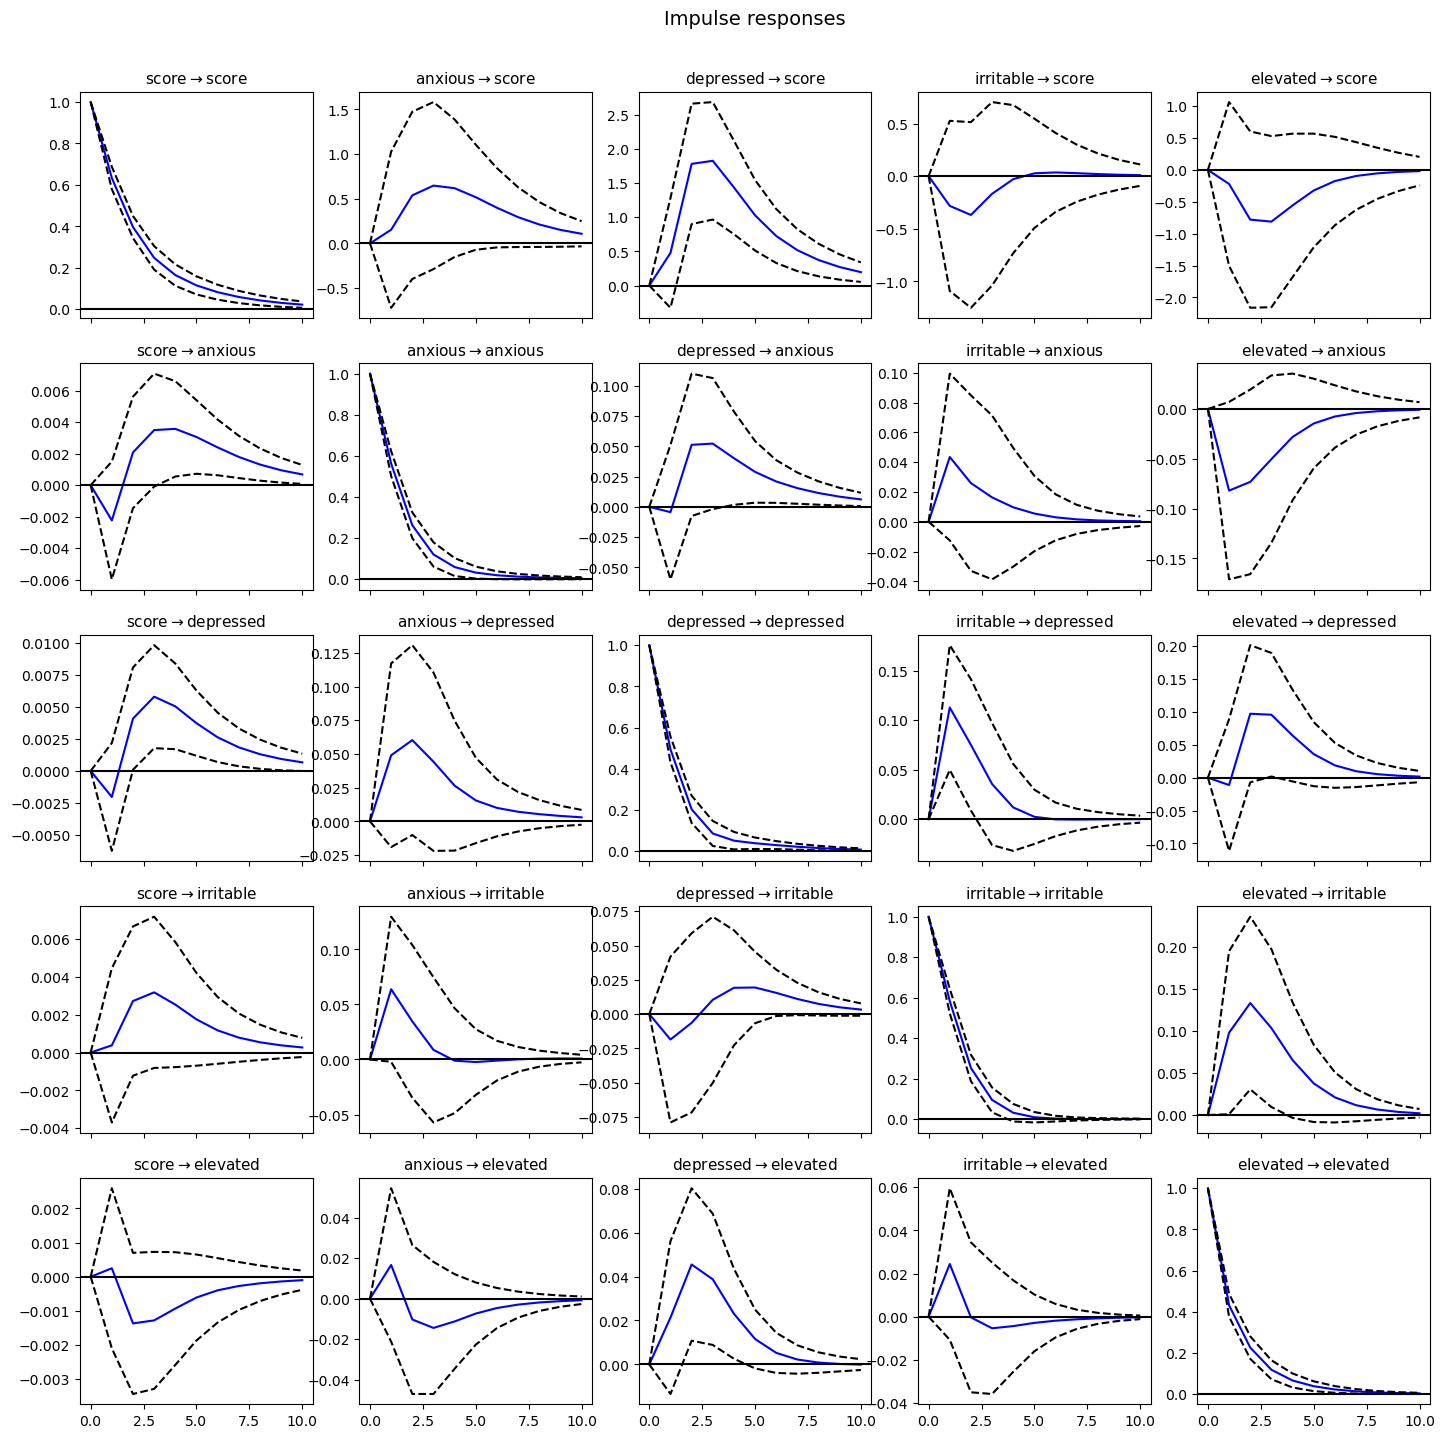

In [79]:
irf = results_var.irf(10)

irf.plot(orth=False, figsize=(15,15), subplot_params={'fontsize': 11});

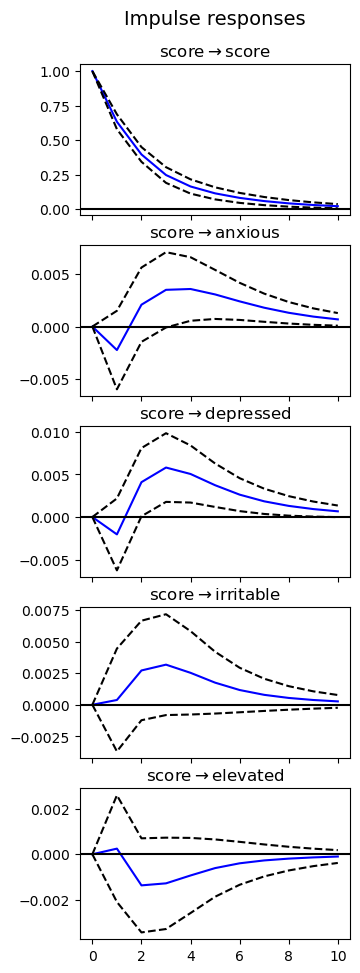

In [81]:
irf.plot(impulse='score', orth=False, figsize=(3,10)).savefig('plots/IRF.png', dpi=300);